# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# !pip install spacy
# !pip install nltk
# !pip install mglearn
# !python -m spacy download en_core_web_sm

In [2]:
import mglearn
import pandas as pd
import numpy as np
import re
import warnings
import spacy
import nltk

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from pymystem3 import Mystem
# загружаем пакеты spacy для английского языка
en_nlp = spacy.load('en_core_web_sm')
warnings.filterwarnings('ignore')

import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams

In [3]:
df = pd.read_csv('toxic_comments.csv')

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
print(f"Длина датасета: {df.shape[0]}")

Длина датасета: 159571


df['text'] представлет собой набор строк, длиной 159571 текст. Кроме того текст содержит различные символы типа \n, !, . и т.д. Так как это в дальнейшем может создать шут для модели, удалим такие символы. Используем регулярные выражения, что бы очистить текст

In [6]:
df['clean_text'] = df['text'].apply(lambda x:re.sub(r'[^a-zA-Z ]', ' ', x))

In [7]:
df.sample()

,text,toxic,clean_text
65517,I can't see why the arabesque spelling is even...,0,I can t see why the arabesque spelling is even...


### train-test-split

In [8]:
X_tr, X_tt, y_train, y_test = train_test_split(df['clean_text'], df['toxic'], test_size=0.2, random_state=12)

In [9]:
assert len(X_tr) == len(y_train)

### bag-of-words

In [10]:
vect = CountVectorizer().fit(X_tr)
X_train = vect.transform(X_tr)
X_test = vect.transform(X_tt)
print(f"X_train:\n{repr(X_train)}")

X_train:
<127656x148254 sparse matrix of type '<class 'numpy.int64'>'
	with 5448579 stored elements in Compressed Sparse Row format>


Матрица X_train соответствует обучающим данным, представленным в виде "мешка слов". Она имеет форму 127656x148254, что указывает на то, что она имеет 148254 элементов.

In [11]:
feature_names = vect.get_feature_names()
print(f"Количество признаков: {len(feature_names)}")
print(f"Первые 20 признаков: {feature_names[:20]}")
print(f"Каждый 10000 признак: {feature_names[::10000]}")

Количество признаков: 148254
Первые 20 признаков: ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaany', 'aaaaaaaaaahhhhhhhhhhhhhh', 'aaaaaaaaadm', 'aaaaaaaaaq', 'aaaaaaaaczy', 'aaaaaaaahhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhhh', 'aaaaaaaari', 'aaaaaaaayui', 'aaaaah', 'aaaannnnyyyywwwwhhhheeeerrrreeee', 'aaaawwww', 'aaaboyz', 'aaaghh', 'aaah', 'aaahhh', 'aaahs']
Каждый 10000 признак: ['aa', 'averbakh', 'cardigan', 'culcorp', 'eke', 'gabette', 'huffpost', 'ket', 'mattitude', 'nonpharmacological', 'podd', 'retrieve', 'slippages', 'thatcher', 'vietcong']


Можно увидеть, что первые 20 признаков не имеют какого-то особого смысла, возможно это были эмоциональные записи.

## Обучение

In [20]:
def display_conf_matrix(y_test, y_pred):
    rcParams['figure.figsize'] = 3, 3
    plt.figure(figsize=(2,2))
    sns.set(font_scale=1.5)
    ax = sns.heatmap((pd.crosstab(y_test, y_pred).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
    ax.set_ylabel("")
    ax.set_xlabel("")
    plt.yticks(rotation=0, size = 15)
    plt.xticks(rotation=0, size = 15)

show_me_result = {}
def show_f1_score(X_test, y_test, est_name):
    y_pred = grid.predict(X_test)
    show_me_result[est_name] = f1_score(y_test, y_pred)
    print(f"f1-score: {f1_score(y_test, y_pred)}")
    return y_pred

### LogisticRegression + cross_val_score

In [13]:
%%time

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)

CPU times: user 1min 33s, sys: 2.74 s, total: 1min 35s
Wall time: 25.5 s


In [14]:
print("Средний скор перекрестной проверки: {:.2f}".format(np.mean(scores)))

Средний скор перекрестной проверки: 0.96


Мы получили 0.96 что в целом говорит о хорошем качестве. Логистическая регрессия имеет параметр регуляризации C, который мы можем настроить с помощью перекрестной проверки:

<div class="alert alert-block alert-info">
<b>Совет: </b> В параметр scoring желательно было передать нашу целевую функцию.
</div>

### LogisticRegression + GridSearchCV

In [15]:
param_grid = {'C': [0.1, 1]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid={'C': [0.1, 1]})

In [16]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры перекрестной проверки: ", grid.best_params_)

Наилучшее значение перекрестной проверки: 0.96
Наилучшие параметры перекрестной проверки:  {'C': 1}


Видим, что метрика осталась прежней.

In [17]:
print(f"Правильность на тестовом наборе: {grid.score(X_test, y_test):.2f}")

Правильность на тестовом наборе: 0.96


Мы ранее видели, что у нас есть неадекватные слова. Так же из-за ошибок в словах мы можем получить токены, которые буду встречаться 1 раз, хотя это может быть частотное слово. Токен который встретился только в одном документе врядли встретится в тестовом документе и по этому вполне может быть бесполезен. С помощью параметра min_df можно задать минимальное количество документов, в котором должен появиться токен что бы попасть в словать.

In [21]:
y_pred = show_f1_score(X_test, y_test, 'LogisticRegression + GridSearchCV')

f1-score: 0.772924308102701


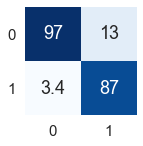

In [22]:
display_conf_matrix(y_test, y_pred)

### LogisticRegression + GridSearchCV + min_df

In [23]:
vect = CountVectorizer(min_df=5).fit(X_tr)
X_train = vect.transform(X_tr)
X_test = vect.transform(X_tt)
print(f"X_train with min_df:\n{repr(X_train)}")

X_train with min_df:
<127656x30832 sparse matrix of type '<class 'numpy.int64'>'
	with 5280578 stored elements in Compressed Sparse Row format>


Мы сократили нашу матрицу с 148254 до 30832 - это почти в 5 раз. Посмотрим снова на токены:

In [24]:
feature_names = vect.get_feature_names()
print(f"Количество признаков: {len(feature_names)}")
print(f"Первые 20 признаков: {feature_names[:20]}")
print(f"Каждый 5000 признак: {feature_names[::5000]}")

Количество признаков: 30832
Первые 20 признаков: ['aa', 'aaa', 'aah', 'aaliyah', 'aap', 'aardvark', 'aaron', 'aaryanrajput', 'aas', 'aave', 'ab', 'aba', 'abad', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abbas', 'abbasid', 'abbey']
Каждый 5000 признак: ['aa', 'closet', 'faint', 'katyn', 'peek', 'sinks', 'whereas']


Видно, что слова стали более адекватные.

In [25]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid={'C': [0.1, 1]})

In [26]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры перекрестной проверки: ", grid.best_params_)

Наилучшее значение перекрестной проверки: 0.96
Наилучшие параметры перекрестной проверки:  {'C': 1}


Я также пробовала на min_df=7, общий результат был один

In [27]:
y_pred = show_f1_score(X_test, y_test, 'LogisticRegression + GridSearchCV + min_df')

f1-score: 0.7670675927494496


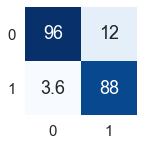

In [28]:
display_conf_matrix(y_test, y_pred)

### LogisticRegression + GridSearchCV + min_df + stop-words

Еще один способ улучшить качество модели - это убрать стол-слова. Проверим это предположение.

In [29]:
print(f"Количество стоп-слов: {len(ENGLISH_STOP_WORDS)}")
print(f"Каждое 10-е стоп слово: {list(ENGLISH_STOP_WORDS)[::10]}")

Количество стоп-слов: 318
Каждое 10-е стоп слово: ['since', 'amongst', 'even', 'everything', 'off', 'whereafter', 'beyond', 'well', 'hasnt', 'myself', 'go', 'such', 'perhaps', 'hundred', 'bill', 'else', 'around', 'why', 'toward', 'hereafter', 'yourself', 'after', 'her', 'hereupon', 'i', 'more', 'indeed', 'whenever', 'whereby', 'though', 'our', 'in']


In [30]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(X_tr)
X_train = vect.transform(X_tr)
X_test = vect.transform(X_tt)
print(f"X_train with min_df:\n{repr(X_train)}")

X_train with min_df:
<127656x30524 sparse matrix of type '<class 'numpy.int64'>'
	with 2976568 stored elements in Compressed Sparse Row format>


In [31]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), param_grid={'C': [0.1, 1]})

In [32]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))

Наилучшее значение перекрестной проверки: 0.96


В целом несколько тысяч слов ничего не изменили, а тут всего 318....

In [33]:
y_pred = show_f1_score(X_test, y_test, 'LogisticRegression + GridSearchCV + min_df + stop-words')

f1-score: 0.7730923694779117


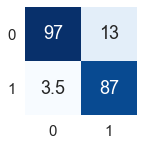

In [34]:
display_conf_matrix(y_test, y_pred)

### LogisticRegression + GridSearchCV + min_df + tf-idf

In [35]:
%%time
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
param_grid = {'logisticregression__C': [0.1, 1]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_tr, y_train)

CPU times: user 2min 55s, sys: 4.26 s, total: 2min 59s
Wall time: 1min 37s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=5, norm=None)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.1, 1]})

In [36]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))

Наилучшее значение перекрестной проверки: 0.96


Масштабирование tf-idf призвано найти слова, которые лучше всего дискриминируют документы, но при этом оно является методом неконтролируемоно обучения. Это значит что "важное" не обязательно значит что оно относится к метке "положительный" или "отрицательный".

In [37]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train = vectorizer.transform(X_tr)
# находим максимальное значение каждого признака по набору данных
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# получаем имена признаков
feature_names = np.array(vectorizer.get_feature_names())

In [38]:
print(f"Признаки с наименьшими значениями tfidf: {feature_names[sorted_by_tfidf[:20]]}")
print(f"Признаки с наибольшими значениями tfidf: {feature_names[sorted_by_tfidf[-20:]]}")

Признаки с наименьшими значениями tfidf: ['experimenting' 'facilitate' 'cheatsheet' 'reaching' 'slight' 'albeit'
 'encountered' 'suffice' 'remotely' 'fantastic' 'unjustified' 'wherever'
 'considerably' 'unspecified' 'assured' 'glance' 'awhile' 'mentored'
 'happily' 'grossly']
Признаки с наибольшими значениями tfidf: ['twat' 'ass' 'fat' 'sex' 'jew' 'die' 'noobs' 'fag' 'faggot' 'nigger'
 'faggots' 'shit' 'aids' 'wanker' 'balls' 'noes' 'teabag' 'lol' 'bark'
 'pig']


Важные слова не такие длинные как неважные.


In [39]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print(f"Признаки с наименьшими значениями idf: {feature_names[sorted_by_idf[:100]]}")

Признаки с наименьшими значениями idf: ['the' 'to' 'and' 'of' 'you' 'is' 'it' 'that' 'in' 'for' 'this' 'not' 'on'
 'be' 'have' 'as' 'are' 'if' 'with' 'but' 'your' 'or' 'article' 'was' 'an'
 'from' 'my' 'do' 'can' 'page' 'at' 'talk' 'so' 'wikipedia' 'by' 'what'
 'about' 'there' 'me' 'please' 'just' 'has' 'all' 'will' 'no' 'would'
 'like' 'one' 'been' 'any' 'more' 'don' 'should' 'which' 'they' 'see'
 'other' 'some' 'here' 'also' 'we' 'think' 'who' 'know' 'because' 'how'
 'out' 'he' 'up' 'only' 'why' 'edit' 'when' 'people' 'time' 'then' 'now'
 'am' 'did' 'thanks' 'being' 'articles' 'his' 'may' 'them' 'than' 'get'
 'make' 're' 'even' 'were' 'use' 'good' 'well' 'does' 'could' 'very'
 'their' 'want' 've']


In [40]:
y_pred = show_f1_score(X_tt, y_test, 'LogisticRegression + GridSearchCV + min_df + tf-idf')

f1-score: 0.7861604997597309


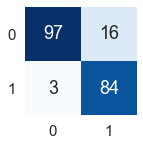

In [41]:
display_conf_matrix(y_test, y_pred)

Слова которые встречаются часто и по этому считаются менее важными. Как и следовало ожидать, словами с низкими значениями метрики tf-idf стали английские стоп слова типа "is", "that", "be"... Интересно что слова "good", "well" так же отнесены к самым часто встречающимся и потому "самым нерелевантным", хотя можно было бы ожидать, что они будут иметь важное значение для анализа тональности.

Один из недостатков bag-of-words является то, что он не учитывает порядка слов. Например строки "it's bad, not good at all" и "it's good, not bad at all" будут иметь одинаковое представление. Употребление частицы "not" - один из примеров. Но нам повезло и есть способ учитывать пары токенов, а еще тройки токенов и т.д.

### LogisticRegression + GridSearchCV + min_df + tf-idf + ngram_range

In [42]:
%%time

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
param_grid = {
    'logisticregression__C': [10],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]
}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_tr, y_train)

CPU times: user 10min 12s, sys: 17.6 s, total: 10min 30s
Wall time: 5min 50s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=5)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [1, 10],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)]})

In [43]:
grid.best_params_

{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 1)}

In [44]:
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))

Наилучшее значение перекрестной проверки: 0.96


Что неудивительно, если лучшее значение ngram = (1, 1), то качество осталось на прежнем уровне.

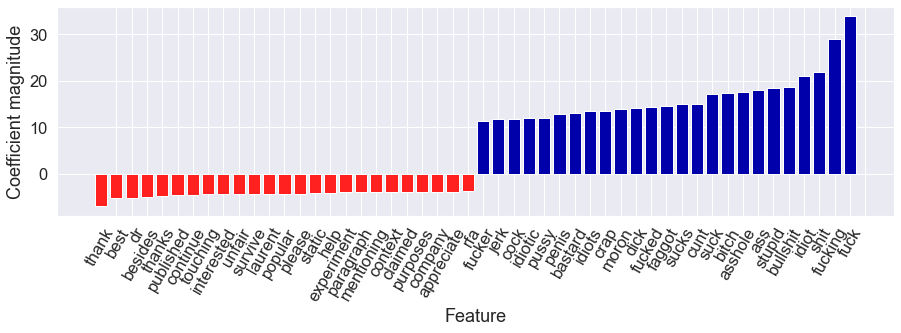

In [45]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=25)

На графике наглядно видно какие слова наиболее важные или имеют наибольший вес при определении комментария как негативный/позитивный

In [46]:
y_pred = show_f1_score(X_tt, y_test, 'LogisticRegression + GridSearchCV + min_df + tf-idf + ngram_range')

f1-score: 0.7953255425709516


Видим, что f-score улучшился

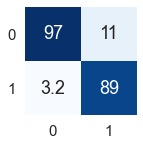

In [47]:
display_conf_matrix(y_test, y_pred)

Так как мы улучшали до последнего наш скор и последний был лучший, попробуем таким образом использовать другие классификаторы

### LogisticRegression + GridSearchCV + min_df + tf-idf + ngram_range + Lemmatization

In [48]:
m = Mystem()

In [49]:
def get_lemma(text):
    new_lemma_text = m.lemmatize(text)
    return " ".join(new_lemma_text)

In [50]:
%%time

df['clean_text_lemma'] = df['clean_text'].apply(get_lemma)

CPU times: user 20.8 s, sys: 1.95 s, total: 22.8 s
Wall time: 1min 29s


In [51]:
df.sample(3)

,text,toxic,clean_text,clean_text_lemma
86781,Looks like the page has been vandalized. Someo...,0,Looks like the page has been vandalized Someo...,Looks like the page has been vanda...
16979,Objetivist theory of value\nThere has to be so...,0,Objetivist theory of value There has to be som...,Objetivist theory of value There has...
127258,"""\nPerhaps it was the time frame. I recall the...",0,Perhaps it was the time frame I recall the ...,Perhaps it was the time frame ...


In [52]:
X_train_lemma, X_test_lemma, y_train, y_test = train_test_split(df['clean_text_lemma'], df['toxic'], test_size=0.2, random_state=12)

In [53]:
%%time

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
param_grid = {
    'logisticregression__C': [10],
    'tfidfvectorizer__ngram_range': [(1, 1)]
}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train_lemma, y_train)

CPU times: user 1min 34s, sys: 2.13 s, total: 1min 36s
Wall time: 53.4 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(min_df=5)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [10],
                         'tfidfvectorizer__ngram_range': [(1, 1)]})

In [54]:
y_pred = show_f1_score(X_test_lemma, y_test, 'LogisticRegression + GridSearchCV + min_df + tf-idf + ngram_range + Lemmatization')

f1-score: 0.7953255425709516


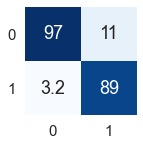

In [55]:
display_conf_matrix(y_test, y_pred)

### CatBoostClassifier + GridSearchCV + min_df + tf-idf

In [ ]:
# %%time
#
# pipe = make_pipeline(TfidfVectorizer(min_df=5), CatBoostClassifier())
# param_grid = {
#     'tfidfvectorizer__ngram_range': [(1, 1)]
# }
# grid = GridSearchCV(pipe, param_grid, cv=3)
# grid.fit(X_tr, y_train)

In [ ]:
# grid.best_params_

In [ ]:
# show_f1_score(X_tt, y_test, 'CatBoostClassifier + GridSearchCV + min_df + tf-idf')

In [ ]:
# display_conf_matrix(y_test, y_pred)

CatBoostClassifier учился очень долго(37 минут) и на базовых параметрах показал себя хуже чем лог регрессия

In [56]:
show_me_result

{'LogisticRegression + GridSearchCV': 0.772924308102701,
 'LogisticRegression + GridSearchCV + min_df': 0.7670675927494496,
 'LogisticRegression + GridSearchCV + min_df + stop-words': 0.7730923694779117,
 'LogisticRegression + GridSearchCV + min_df + tf-idf': 0.7861604997597309,
 'LogisticRegression + GridSearchCV + min_df + tf-idf + ngram_range': 0.7953255425709516,
 'LogisticRegression + GridSearchCV + min_df + tf-idf + ngram_range + Lemmatization': 0.7953255425709516}

## Выводы

Построили несколько моделей с различной предобработкой. Сделали выводы:
- Добавление параметра min_df сократило количество признаков, и немного ухудьшило качество. Скорость обучения выросла
- Наличие stop-words улучшает качество, т.к. убирает не значимые признаки
- Масштабирование с помощью tf-idf дает улучшение качества
- Разбиение на n-граммы дает улучшение, но к сожалению не оправдалость предположение что двуграммы лучше себя покажут
- Лемматизация не сработала, возможно она не работает с английским языком

Можно добавить что все улучшения дали прирост в сотые метрики f-меры. То есть по сути дефолтная модель и так работает не плохо.
По итогу я бы взяла модель ngram_range, так как она дает оптимальное соотношение FP и FN, FP меньше чем в остальных моделях - на модерацию комментариев уйдет не много времени, а FN в целом тоже немного - пропущенных токсичных комментариев мало. Если исходить из задачи "не пропустить токсичные комментарии, при этом не сильно нагружать модераторов" - эта модель лучше всех подойдет.